In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR, AdaBoostRegressor as ABR, BaggingRegressor as BR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor as CBR

In [2]:
from sklearn.model_selection import GridSearchCV  
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from lightgbm import LGBMRegressor as LGBMR
from sklearn.svm import SVR
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

In [3]:
fl = pd.read_csv("../data/ML/clean_data_for_ML.csv")

In [4]:
fl = fl[fl.duration.notna()]

In [5]:
fl.columns

Index(['arr_mins_of_delay', 'week_day', 'week_num', 'day_time',
       'cod_flight_IATA', 'cod_airliner_IATA', 'cod_airport_IATA', 'duration',
       'Temperature', 'Wind', 'acc_Gusts', 'Relative_hum', 'Pressure',
       'Condition', 'acc_bad_weather'],
      dtype='object')

In [6]:
fl = fl.drop(columns = ['cod_flight_IATA','cod_airport_IATA','Relative_hum','Pressure',])

In [7]:
# fl = fl[fl.arr_mins_of_delay <= 120]

In [8]:
fl = fl[fl['arr_mins_of_delay'] > 0]

In [9]:
fl.shape

(288310, 13)

In [10]:
(fl[fl.arr_mins_of_delay >= 30].shape[0] / fl.shape[0])*100

24.671360688148177

In [11]:
# Condiciones para las categorías
conditions = [
    (fl['arr_mins_of_delay'] < 30),
    (fl['arr_mins_of_delay'] >= 30)]

# conditions = [
#     (fl['arr_mins_of_delay'] < 20),
#     (fl['arr_mins_of_delay'] >= 20) & (fl['arr_mins_of_delay'] < 60),
#     (fl['arr_mins_of_delay'] >= 60) & (fl['arr_mins_of_delay'] < 120),
#     (fl['arr_mins_of_delay'] >= 120)
# ]
# Valores correspondientes a las categorías
values = ['type1', 'type2']

# Crear la nueva columna 'delay' basada en las condiciones
fl['delay'] = np.select(conditions, values)

In [12]:
fl.delay.value_counts()

type1    217180
type2     71130
Name: delay, dtype: int64

C:\Users\daarr\AppData\Local\Temp\ipykernel_6072\1970479324.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask=np.triu(np.ones_like(fl.corr(), dtype=bool))    # mascara para tapar lo de arriba
C:\Users\daarr\AppData\Local\Temp\ipykernel_6072\1970479324.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(fl.corr(),


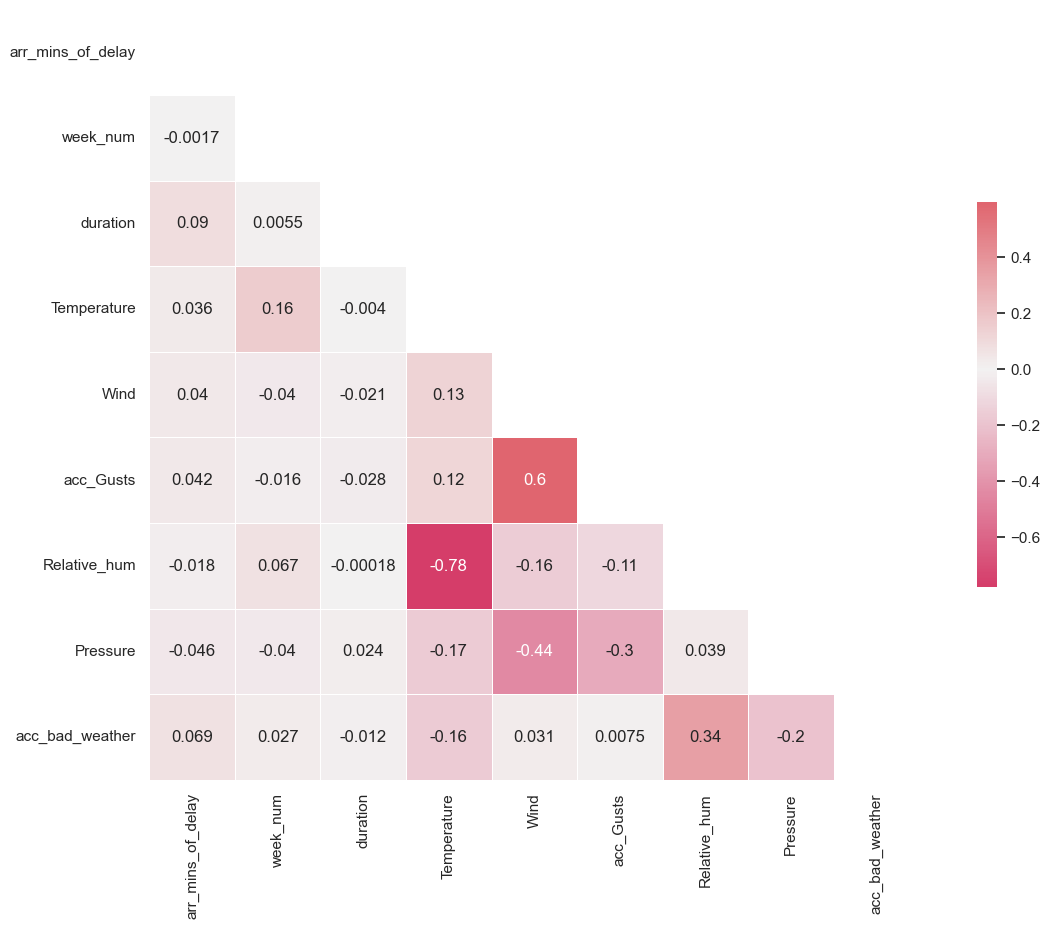

In [13]:
plt.figure(figsize=(15, 10))   # 150x100 pixeles

sns.set(style='white')    # estilo blanco

mask=np.triu(np.ones_like(fl.corr(), dtype=bool))    # mascara para tapar lo de arriba

cmap=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de  colores


sns.heatmap(fl.corr(),    
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

In [14]:
# fl['week_num'] = fl['week_num'].astype('object')

In [15]:
# # Convertir las columnas a categóricas
# columns_to_convert = ['week_num', 'Condition', 'week_day', 'day_time', 'cod_airliner_IATA']

# fl[columns_to_convert] = fl[columns_to_convert].astype('category')

In [16]:
fl=pd.get_dummies(fl, columns = ['Condition','day_time',
                       'week_day','week_num','cod_airliner_IATA'], drop_first=True)


In [17]:
X = fl.drop('arr_mins_of_delay', axis=1)

y = fl.arr_mins_of_delay

In [18]:
X_train, X_test, y_train, y_test = tts(X, y, 
                                       train_size=0.8, 
                                       test_size=0.2
                                      ,random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230648, 186), (57662, 186), (230648,), (57662,))

In [19]:
X_tscore = X_test["delay"]

In [20]:
X_train = X_train.drop('delay', axis=1)

In [21]:
X_test = X_test.drop('delay', axis=1)

In [22]:
fl.columns

Index(['arr_mins_of_delay', 'duration', 'Temperature', 'Wind', 'acc_Gusts',
       'Relative_hum', 'Pressure', 'acc_bad_weather', 'delay',
       'Condition_Chance of Showers',
       ...
       'cod_airliner_IATA_TS', 'cod_airliner_IATA_TU', 'cod_airliner_IATA_U2',
       'cod_airliner_IATA_UA', 'cod_airliner_IATA_UX', 'cod_airliner_IATA_V7',
       'cod_airliner_IATA_VY', 'cod_airliner_IATA_W6', 'cod_airliner_IATA_WT',
       'cod_airliner_IATA_YW'],
      dtype='object', length=187)

In [23]:
escalador = StandardScaler()    # inicia el normalizador
 
X_train[['duration', 'Wind', 'acc_Gusts','acc_bad_weather','Temperature',]] = escalador.fit_transform(X_train[['duration', 'Wind', 'acc_Gusts','acc_bad_weather','Temperature',]])   # transforma train
X_test[['duration', 'Wind', 'acc_Gusts','acc_bad_weather','Temperature',]] = escalador.transform(X_test[['duration', 'Wind', 'acc_Gusts','acc_bad_weather','Temperature',]])  # transforma test

In [24]:
X_train.head()

,duration,Temperature,Wind,acc_Gusts,Relative_hum,Pressure,acc_bad_weather,Condition_Chance of Showers,Condition_Clear,Condition_Cloudy,...,cod_airliner_IATA_TS,cod_airliner_IATA_TU,cod_airliner_IATA_U2,cod_airliner_IATA_UA,cod_airliner_IATA_UX,cod_airliner_IATA_V7,cod_airliner_IATA_VY,cod_airliner_IATA_W6,cod_airliner_IATA_WT,cod_airliner_IATA_YW
522089,2.000390,1.026474,-0.223981,-0.460978,-1.207105,0.668999,-0.294298,0,1,0,...,0,0,0,0,1,0,0,0,0,0
33452,-0.331698,-1.498397,-0.003655,-0.460978,1.812003,-2.886958,2.662965,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111427,-0.331698,0.016526,-0.444308,0.157250,-0.187666,-0.664485,-0.294298,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663547,-0.331698,2.036423,1.318305,2.668801,-1.599197,-0.219991,-0.294298,0,1,0,...,0,0,0,0,0,0,0,0,0,0
675025,0.334613,1.127469,1.318305,2.861997,-1.246314,-1.108980,-0.294298,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# models = {
#     "linear_regression": LinearRegression(),
#     "ridge_regression": Ridge(),
#     "lasso_regression": Lasso(),
#     "decision_tree_regressor": DecisionTreeRegressor(),
#     "random_forest_regressor": RFR(n_jobs = 8),
#     "gradient_boosting_regressor": GBR(),
#     "mlp_regressor": MLPRegressor(),
#     "elastic_net": ElasticNet(),
#     "ada_boost_regressor": ABR(),
#     "bagging_regressor": BR(),
#     "CatBoostRegressor": CBR(),
#     "XGBRegressor" : XGBRegressor(),
#     "LGBMRegressor": LGBMR()
# }

In [26]:
# def fit_and_score(models, X_train, X_test, y_train, y_test):
#     """
#     Fits the given machine learning models to the training data and evaluates their performance on the test data.
#     Parameters:
#     - models (dict): A dictionary where keys are model names and values are the corresponding machine learning models.
#     - X_train (array-like): Feature matrix of the training set.
#     - X_test (array-like): Feature matrix of the test set.
#     - y_train (array-like): True labels of the training set.
#     - y_test (array-like): True labels of the test set.
#     Returns:
#     dict: A dictionary where keys are model names and values are their corresponding accuracy scores on the test set.
#     This function takes a dictionary of machine learning models and fits each model to the training data.
#     It then evaluates the performance of each model on the provided test data using the `score` method,
#     and returns a dictionary of model names and their corresponding accuracy scores.
#     """
#     model_scores = {}
#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         model_scores[name] = round(mse(y_test, y_pred, squared=False), 5)
#     return model_scores

In [27]:
# pd.set_option('display.max_rows', None)
# print(X_train.isnull().sum())

In [28]:
# fit_and_score(models, X_train, X_test, y_train, y_test)

In [29]:
model = RFR(n_jobs = 8) 

In [30]:
# cat_features = ['week_num', 'Condition', 'week_day', 'day_time', 'cod_airliner_IATA']

model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=8)

In [31]:
y_pred_RFR = model.predict(X_test)
print(mean_squared_error(y_test, y_pred_RFR, squared=False))

34.74784761301788


In [32]:
y_pred_RFR.max()

283.8

In [33]:
y_pred_RFR[:20]

array([11.80414286, 13.41666667, 19.91489683, 20.47333333, 42.15083333,
       31.77966667, 33.53166667, 46.37      , 29.10810317, 12.96      ,
       50.4       , 25.033     , 12.32980952, 10.73      , 38.66833333,
       26.705     , 15.65433333, 19.84142857, 11.0957381 , 32.35166667])

In [34]:
y_test.head(20)

740258     5
240895     1
404454    26
61195      9
218115    12
314697    36
111657    36
665949    56
539306    31
120433     1
113       37
196703     4
433550    75
124251     3
503729     4
196251    10
186913     1
854014     3
455044    24
688368    44
Name: arr_mins_of_delay, dtype: int64

In [35]:
type(y_pred_RFR)

numpy.ndarray

In [36]:
type(X_tscore)

pandas.core.series.Series

In [37]:
type(y_test)

pandas.core.series.Series

In [38]:
# Crear un DataFrame
fl_score = pd.DataFrame({
    'Tipo_test': X_tscore,
    'Valor_test': y_test,
    'Prediccion': y_pred_RFR
})

In [39]:
# Condiciones para las categorías
conditions = [
    (fl_score['Prediccion'] < 30),
    (fl_score['Prediccion'] >= 30) 
]

# Valores correspondientes a las categorías
values = ['type1', 'type2']

# Crear la nueva columna 'delay' basada en las condiciones
fl_score['Tipo_prediccion'] = np.select(conditions, values)

In [40]:
fl_score['acierto'] = (fl_score['Tipo_test'] == fl_score['Tipo_prediccion'])

In [41]:
fl_score.head(20)

,Tipo_test,Valor_test,Prediccion,Tipo_prediccion,acierto
740258,type1,5,11.804143,type1,True
240895,type1,1,13.416667,type1,True
404454,type1,26,19.914897,type1,True
61195,type1,9,20.473333,type1,True
218115,type1,12,42.150833,type2,False
314697,type2,36,31.779667,type2,True
111657,type2,36,33.531667,type2,True
665949,type2,56,46.370000,type2,True
539306,type2,31,29.108103,type1,False
120433,type1,1,12.960000,type1,True


In [42]:
fl_score.groupby('Tipo_test').agg({'acierto':'sum'})

,acierto
Tipo_test,
type1,34047
type2,5921


In [43]:
print(fl_score.acierto.value_counts()[0]/len(fl_score)*100)
print(fl_score.acierto.value_counts()[1]/len(fl_score)*100)

69.31427976830496
30.68572023169505


In [44]:
fl_score.Tipo_test.value_counts()

type1    43395
type2    14267
Name: Tipo_test, dtype: int64

In [45]:
fl_score.Tipo_prediccion.value_counts()

type1    42393
type2    15269
Name: Tipo_prediccion, dtype: int64